In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import requests 
from urllib.parse import urlencode
import numpy as np

В данном проекте я буду читать файлы с облака Яндекс Диска не скачивая их на локальный компьютер и не подгружая в репозиторий. Для этого использую api и оборачиваю работу с ним в функцию, чтобы не использовать при чтении каждого датафрейма такой большой кусок кода и сразу вызывать её в функции read_csv.

In [2]:
def read_csv_from_yandex_disk(public_key):
    # используем api
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 

    # получаем url 
    final_url = base_url + urlencode(dict(public_key=public_key)) 
    response = requests.get(final_url) 
    download_url = response.json()['href'] 

    # загружаем файл в df 
    download_response = requests.get(download_url) 
    return download_url

**Датафрейм assesments**

In [3]:
df_assessments = pd.read_csv(read_csv_from_yandex_disk('https://disk.yandex.ru/d/iSVP1sZ7AdW7TQ'))

In [4]:
df_assessments.head(10)

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0
5,AAA,2013J,1757,Exam,NaN,100.0
6,AAA,2014J,1758,TMA,19.0,10.0
7,AAA,2014J,1759,TMA,54.0,20.0
8,AAA,2014J,1760,TMA,117.0,20.0
9,AAA,2014J,1761,TMA,166.0,20.0


Датафрейм assessments содержит информацию об оценках в тесте. Обычно каждый предмет в семестре включает ряд тестов с оценками, за которыми следует заключительный экзаменационный тест (экзамен).
В обзорном срезе датафрейма нам уже попалось пропущенное значение, поэтому стоит изучить их подробнее.

In [5]:
df_assessments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   code_module        206 non-null    object 
 1   code_presentation  206 non-null    object 
 2   id_assessment      206 non-null    int64  
 3   assessment_type    206 non-null    object 
 4   date               195 non-null    float64
 5   weight             206 non-null    float64
dtypes: float64(2), int64(1), object(3)
memory usage: 9.8+ KB


In [6]:
df_assessments_none = df_assessments[df_assessments.isna().any(axis=1)]
df_assessments_none

,code_module,code_presentation,id_assessment,assessment_type,date,weight
5,AAA,2013J,1757,Exam,NaN,100.0
11,AAA,2014J,1763,Exam,NaN,100.0
23,BBB,2013B,14990,Exam,NaN,100.0
35,BBB,2013J,15002,Exam,NaN,100.0
47,BBB,2014B,15014,Exam,NaN,100.0
53,BBB,2014J,15025,Exam,NaN,100.0
62,CCC,2014B,24290,Exam,NaN,100.0
63,CCC,2014B,40087,Exam,NaN,100.0
72,CCC,2014J,24299,Exam,NaN,100.0
73,CCC,2014J,40088,Exam,NaN,100.0


При изучении пропущенных значений вижу некоторую закономерность, что пропущенные значения есть только у даты сдачи некоторых экзаменов. Дата сдачи тестов есть так же и в другой таблице, поэтому пока очищать таблицу от пропущенных значений не буду и соберу идентификаторы тестов в отдельную переменную, чтобы продолжить изучение причин отсутствия этих значений. Пока можно сделать первое предположение о том, что, возможно, у этих экзаменов нет конкретной даты сдачи и их можно сдавать в определенный период в разные дни.

**Также данный срез данных позволяет определить что можно считать курсом. Ввожу понятие курса - это определенный предмет (code_module) который читается в определенном семестре (code_presentation) в конце которого сдается экзамен, успешность сдачи которого определяет успешность прохождения всего курса.**

In [7]:
nones_exams = list(df_assessments_none.id_assessment)

**Датафрейм courses**

In [8]:
df_courses = pd.read_csv(read_csv_from_yandex_disk('https://disk.yandex.ru/d/jmJxR8yhwCXlaw'))

In [9]:
df_courses.head(10)

,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269
2,BBB,2013J,268
3,BBB,2014J,262
4,BBB,2013B,240
5,BBB,2014B,234
6,CCC,2014J,269
7,CCC,2014B,241
8,DDD,2013J,261
9,DDD,2014J,262


Датафрейм courses содержит список предметов по семестрам

In [10]:
df_courses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 3 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   code_module                 22 non-null     object
 1   code_presentation           22 non-null     object
 2   module_presentation_length  22 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 656.0+ bytes


**Датафрейм studentAssessment**

In [11]:
df_studentAssessment = pd.read_csv(read_csv_from_yandex_disk('https://disk.yandex.ru/d/DYd4M5b_8RETsA'))

In [12]:
df_studentAssessment.head(10)

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0
5,1752,45462,20,0,70.0
6,1752,45642,18,0,72.0
7,1752,52130,19,0,72.0
8,1752,53025,9,0,71.0
9,1752,57506,18,0,68.0


Датафрейм studentAssessment содержит результаты тестов студентов. Если учащийся не отправляет работу на оценку, результат не записывается в таблицу.

В этой таблице есть колонка с датой сдачи теста, которая позволит продолжить исследование пропущенных значений дат в датафрейме assessments.

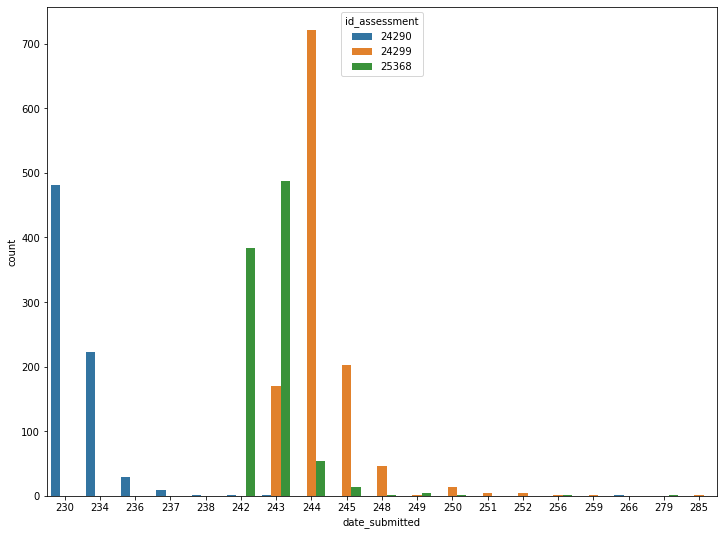

In [13]:
plt.figure(figsize=(12,9))
sns.countplot(data=df_studentAssessment.query("id_assessment in @nones_exams"), x='date_submitted', hue='id_assessment')

По распределению дат из списка экзаменов в которых не было проставлено конкретной даты сдачи видно, что эти экзамены сдавались в разные дни, что пока позволяет подтвердить теорию, что у этих экзаменов нет конкретной даты сдачи и нет оснований очищать данные от этих пропусков.

In [14]:
df_studentAssessment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173912 entries, 0 to 173911
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id_assessment   173912 non-null  int64  
 1   id_student      173912 non-null  int64  
 2   date_submitted  173912 non-null  int64  
 3   is_banked       173912 non-null  int64  
 4   score           173739 non-null  float64
dtypes: float64(1), int64(4)
memory usage: 6.6 MB


In [15]:
df_studentAssessment[df_studentAssessment.isna().any(axis=1)]

,id_assessment,id_student,date_submitted,is_banked,score
215,1752,721259,22,0,NaN
937,1754,260355,127,0,NaN
2364,1760,2606802,180,0,NaN
3358,14984,186780,77,0,NaN
3914,14984,531205,26,0,NaN
...,...,...,...,...,...
148929,34903,582670,241,0,NaN
159251,37415,610738,87,0,NaN
166390,37427,631786,221,0,NaN
169725,37435,648110,62,0,NaN


В этой таблице есть пропуски в значениях проставленной оценки и прежде чем очищать данные от пропусков, я попробую выяснить причину этих пропусков. Первоначальная гипотеза - данные тесты сдавались после дедлайна, вследствие чего тест не был принят и оценка не была выставлена. Для проверки гипотезы я хочу смержить срез данных с пропусками с табличкой assessment, так как в ней есть даты сдачи тестов.

In [16]:
df_studentAssessment[df_studentAssessment.isna().any(axis=1)].merge(df_assessments, on='id_assessment')

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight
0,1752,721259,22,0,NaN,AAA,2013J,TMA,19.0,10.0
1,1754,260355,127,0,NaN,AAA,2013J,TMA,117.0,20.0
2,1760,2606802,180,0,NaN,AAA,2014J,TMA,117.0,20.0
3,14984,186780,77,0,NaN,BBB,2013B,TMA,19.0,5.0
4,14984,531205,26,0,NaN,BBB,2013B,TMA,19.0,5.0
...,...,...,...,...,...,...,...,...,...,...
168,34903,582670,241,0,NaN,FFF,2014J,TMA,199.0,25.0
169,37415,610738,87,0,NaN,GGG,2013J,TMA,61.0,0.0
170,37427,631786,221,0,NaN,GGG,2014B,TMA,166.0,0.0
171,37435,648110,62,0,NaN,GGG,2014J,TMA,61.0,0.0


In [17]:
df_studentAssessment[df_studentAssessment.isna().any(axis=1)].merge(df_assessments, on='id_assessment') \
                    .query('date_submitted > date')

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight
0,1752,721259,22,0,NaN,AAA,2013J,TMA,19.0,10.0
1,1754,260355,127,0,NaN,AAA,2013J,TMA,117.0,20.0
2,1760,2606802,180,0,NaN,AAA,2014J,TMA,117.0,20.0
3,14984,186780,77,0,NaN,BBB,2013B,TMA,19.0,5.0
4,14984,531205,26,0,NaN,BBB,2013B,TMA,19.0,5.0
...,...,...,...,...,...,...,...,...,...,...
167,34902,489553,241,0,NaN,FFF,2014J,TMA,136.0,25.0
168,34903,582670,241,0,NaN,FFF,2014J,TMA,199.0,25.0
169,37415,610738,87,0,NaN,GGG,2013J,TMA,61.0,0.0
170,37427,631786,221,0,NaN,GGG,2014B,TMA,166.0,0.0


Заметно, что из всех пропущенных оценок за тесты только 77% сдавали после дедлайна. Четкой закономерности нет, поэтому гипотезу о невозможности сдачи теста после дедлайна подтвердить не представляется возможным. Попробую также отследить на изначальном датасете, есть ли вообще случаи успешной сдачи теста после дедлайна.

In [18]:
df_studentAssessment.merge(df_assessments, on='id_assessment') \
                    .query('date_submitted > date')

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight
1,1752,28400,22,0,70.0,AAA,2013J,TMA,19.0,10.0
3,1752,32885,26,0,69.0,AAA,2013J,TMA,19.0,10.0
5,1752,45462,20,0,70.0,AAA,2013J,TMA,19.0,10.0
17,1752,74372,22,0,60.0,AAA,2013J,TMA,19.0,10.0
20,1752,91265,21,0,75.0,AAA,2013J,TMA,19.0,10.0
...,...,...,...,...,...,...,...,...,...,...
173881,37443,340242,230,0,80.0,GGG,2014J,CMA,229.0,0.0
173885,37443,358341,230,0,20.0,GGG,2014J,CMA,229.0,0.0
173889,37443,380668,231,0,0.0,GGG,2014J,CMA,229.0,0.0
173896,37443,465952,230,0,80.0,GGG,2014J,CMA,229.0,0.0


Видно, что случаев успешной сдачи после дедлайна достаточно много, поэтому гипотезу про невозможность сдачи после дедлайна можно отвергнуть.
Теперь можно подумать как преобразовать пропущенные данные в этой таблице. Можно удалить строки с пропущенными значениями из таблицы, а также можно заменить оценку нулями или средними значениями. Для этого я хочу посмотреть на распределение оценок.

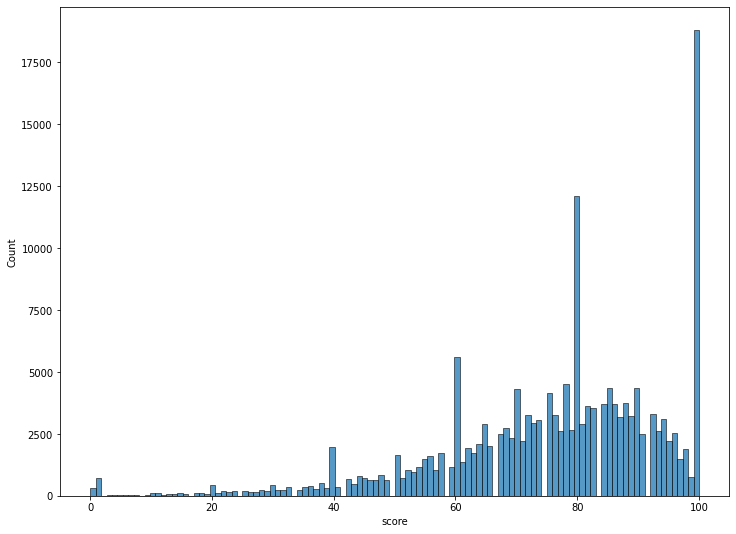

In [19]:
plt.figure(figsize=(12,9))
sns.histplot(data=df_studentAssessment, x='score')

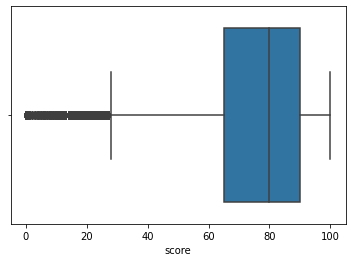

In [20]:
sns.boxplot(data=df_studentAssessment, x='score')

На графике боксплот видны потенциальные аутлайнеры (значения <25). По логике понимаем, что это те люди, которые неудачно сдали тест и если они пересдавали, и пересдали успешно, то они также есть и в распределении от 40 до 100 баллов. В связи с этим было бы нелогично заменять пропущенные значения оценок средними значениями, так как из-за присутствия не сдавших тест, среднее будет смещаться в меньшую сторону, а медианная оценка лично мне представляется слишком высокой, поэтому будет логично просто очистить датафрейм от пропущенных значений.

Выбросы на значениях 40, 60, 80, 100 можно потенциально объяснить особенностью тестов. Предположительно, тесты могут состоять, например, из 5 вопросов и правильный ответ будет стоит 20 баллов, так как система оценивания в 100-бальной шкале.

In [21]:
df_studentAssessment = df_studentAssessment.dropna()

**Датасет studentRegistration**

In [22]:
df_studentRegistration = pd.read_csv(read_csv_from_yandex_disk('https://disk.yandex.ru/d/lqHnH8NOZ458iw'))

In [23]:
df_studentRegistration.head(10)

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159.0,NaN
1,AAA,2013J,28400,-53.0,NaN
2,AAA,2013J,30268,-92.0,12.0
3,AAA,2013J,31604,-52.0,NaN
4,AAA,2013J,32885,-176.0,NaN
5,AAA,2013J,38053,-110.0,NaN
6,AAA,2013J,45462,-67.0,NaN
7,AAA,2013J,45642,-29.0,NaN
8,AAA,2013J,52130,-33.0,NaN
9,AAA,2013J,53025,-179.0,NaN


Датасет studentRegistration содержит информацию о времени, когда студент зарегистрировался для прохождения курса в семестре. Здесь есть пропуски в датах отмены регистрации, но так как эти пропуски несут информацию о том, что студент не уходил с курса, эти пропуски я оставляю

In [24]:
df_studentRegistration.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   code_module          32593 non-null  object 
 1   code_presentation    32593 non-null  object 
 2   id_student           32593 non-null  int64  
 3   date_registration    32548 non-null  float64
 4   date_unregistration  10072 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 1.2+ MB


Есть небольшое количество пропусков в дате регистрации. Буду считать, что это ошибка при заполнении или же что студент тольк заполнил заявку, но не зарегистрировался. Я очищу датафрейм от этих пропусков, так как они несут мало информации и очень сложны в обработке.

In [25]:
df_studentRegistration = df_studentRegistration.dropna(subset=['date_registration'])

**Задание 1**

Сколько студентов успешно сдали только один курс? (Успешная сдача — это зачёт по курсу на экзамене) (7 баллов).

Отфильтрую тесты по типу и успешности их сдачи и посчитаю сколько студентов сдало только один экзамен

In [26]:
exams_id = list(df_assessments.query("assessment_type == 'Exam'").id_assessment)

In [27]:
df_studentAssessment.query('id_assessment in @exams_id & score >= 40') \
                    .groupby('id_student', as_index=False) \
                    .agg({'id_assessment': 'count'}) \
                    .query('id_assessment == 1') \
                    .id_assessment.sum()

3802

**Ответ:** 3802 студента сдали только один курс

**Задание 2**

Выяви самый сложный и самый простой экзамен: найди курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью*. (10 баллов)

*завершаемость* = кол-во успешных экзаменов / кол-во всех попыток сдать экзамен

In [28]:
df_success_exams = df_studentAssessment.merge(df_assessments, on='id_assessment') \
                    .query("assessment_type == 'Exam'")
df_success_exams

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight
52862,24290,558914,230,0,32.0,CCC,2014B,Exam,NaN,100.0
52863,24290,559706,234,0,78.0,CCC,2014B,Exam,NaN,100.0
52864,24290,559770,230,0,54.0,CCC,2014B,Exam,NaN,100.0
52865,24290,560114,230,0,64.0,CCC,2014B,Exam,NaN,100.0
52866,24290,560311,234,0,100.0,CCC,2014B,Exam,NaN,100.0
...,...,...,...,...,...,...,...,...,...,...
95864,25368,652680,243,0,91.0,DDD,2014J,Exam,NaN,100.0
95865,25368,652732,249,0,47.0,DDD,2014J,Exam,NaN,100.0
95866,25368,652965,242,0,87.0,DDD,2014J,Exam,NaN,100.0
95867,25368,653051,242,0,27.0,DDD,2014J,Exam,NaN,100.0


Для расчета доли завершаемости я хочу дать каждой зафиксированной сдаче дать характеристику через pd.cut

Также учитываю, что в аргументе bins левые границы интервалов не входят

In [29]:
df_success_exams['success_label'] = pd.cut(df_success_exams.score, bins=[-1, 39, 100], labels=['bad', 'good'])
df_success_exams

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight,success_label
52862,24290,558914,230,0,32.0,CCC,2014B,Exam,NaN,100.0,bad
52863,24290,559706,234,0,78.0,CCC,2014B,Exam,NaN,100.0,good
52864,24290,559770,230,0,54.0,CCC,2014B,Exam,NaN,100.0,good
52865,24290,560114,230,0,64.0,CCC,2014B,Exam,NaN,100.0,good
52866,24290,560311,234,0,100.0,CCC,2014B,Exam,NaN,100.0,good
...,...,...,...,...,...,...,...,...,...,...,...
95864,25368,652680,243,0,91.0,DDD,2014J,Exam,NaN,100.0,good
95865,25368,652732,249,0,47.0,DDD,2014J,Exam,NaN,100.0,good
95866,25368,652965,242,0,87.0,DDD,2014J,Exam,NaN,100.0,good
95867,25368,653051,242,0,27.0,DDD,2014J,Exam,NaN,100.0,bad


In [30]:
df_success_exams = df_success_exams.groupby(['id_assessment', 'success_label'], as_index=False) \
                    .agg({'id_student': 'count'}) \
                    .rename(columns={'id_student': 'exams'})
df_success_exams

,id_assessment,success_label,exams
0,24290,bad,83
1,24290,good,664
2,24299,bad,149
3,24299,good,1019
4,25340,bad,98
5,25340,good,504
6,25354,bad,90
7,25354,good,878
8,25361,bad,39
9,25361,good,485


In [31]:
df_success_exams = df_success_exams.pivot(index='id_assessment', columns='success_label', values='exams')
df_success_exams

success_label,bad,good
id_assessment,,
24290,83,664
24299,149,1019
25340,98,504
25354,90,878
25361,39,485
25368,108,842


In [32]:
df_success_exams.columns = df_success_exams.columns.astype(str)
df_success_exams = df_success_exams.reset_index()
df_success_exams

success_label,id_assessment,bad,good
0,24290,83,664
1,24299,149,1019
2,25340,98,504
3,25354,90,878
4,25361,39,485
5,25368,108,842


In [33]:
df_success_exams['successfull'] = (df_success_exams['good'] / (df_success_exams['bad'] + df_success_exams['good'])) * 100
df_success_exams = df_success_exams.sort_values(by='successfull', ascending=False)
df_success_exams

success_label,id_assessment,bad,good,successfull
4,25361,39,485,92.557252
3,25354,90,878,90.702479
0,24290,83,664,88.888889
5,25368,108,842,88.631579
1,24299,149,1019,87.243151
2,25340,98,504,83.720930


Резюмируя код выше, характеристика успешности сдачи через лейблы позволила мне посчитать количество проваленных и успешных попыток сдачи и на основе этого создать сводную таблицу, с помощью которая была посчитана итоговая доля завершаемости курсов. Дальше необходимо добавть с этой таблице информацию о том, к каким курсам эти значения относятся.

In [34]:
df_success_exams = df_success_exams.merge(df_assessments, on='id_assessment')
df_success_exams

,id_assessment,bad,good,successfull,code_module,code_presentation,assessment_type,date,weight
0,25361,39,485,92.557252,DDD,2014B,Exam,241.0,100.0
1,25354,90,878,90.702479,DDD,2013J,Exam,261.0,100.0
2,24290,83,664,88.888889,CCC,2014B,Exam,NaN,100.0
3,25368,108,842,88.631579,DDD,2014J,Exam,NaN,100.0
4,24299,149,1019,87.243151,CCC,2014J,Exam,NaN,100.0
5,25340,98,504,83.720930,DDD,2013B,Exam,240.0,100.0


**Ответ:**

Курс с самой высокой завершаемостью - DDD в семестре 2014В c долей 92.6%

Курс с самой низкой завершаемостью - DDD в семестре 2013В c долей 83.7%

**Задание 3**

По каждому предмету определи средний срок сдачи экзаменов (под сдачей понимаем последнее успешное прохождение экзамена студентом). (7 баллов)

Так как в задании есть условие о том, что учитывается только последнее успешное прохождение экзамена для подсчета среднего времени сдачи, то сразу же делаю фильтр на проходной балл

In [35]:
df_avg_time_exams = df_studentAssessment.merge(df_assessments, on='id_assessment') \
                    .query("assessment_type == 'Exam' & score >= 40")
df_avg_time_exams

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight
52863,24290,559706,234,0,78.0,CCC,2014B,Exam,NaN,100.0
52864,24290,559770,230,0,54.0,CCC,2014B,Exam,NaN,100.0
52865,24290,560114,230,0,64.0,CCC,2014B,Exam,NaN,100.0
52866,24290,560311,234,0,100.0,CCC,2014B,Exam,NaN,100.0
52867,24290,560494,230,0,92.0,CCC,2014B,Exam,NaN,100.0
...,...,...,...,...,...,...,...,...,...,...
95862,25368,652617,243,0,56.0,DDD,2014J,Exam,NaN,100.0
95864,25368,652680,243,0,91.0,DDD,2014J,Exam,NaN,100.0
95865,25368,652732,249,0,47.0,DDD,2014J,Exam,NaN,100.0
95866,25368,652965,242,0,87.0,DDD,2014J,Exam,NaN,100.0


Также делаю предположение, что некоторые студенты могут записываться на один и тот же предмет в разных семестрах независимо от успешности сдачи прошлого раза и я проверю это с помощью поиска дубликатов по айди студента и предмету

In [36]:
df_avg_time_exams[df_avg_time_exams.duplicated(['id_student', 'code_module'])]

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight
87469,25361,540758,234,0,60.0,DDD,2014B,Exam,241.0,100.0
95595,25368,593903,243,0,44.0,DDD,2014J,Exam,NaN,100.0
95633,25368,605118,243,0,64.0,DDD,2014J,Exam,NaN,100.0


Действительно, такие студенты есть в данной базе. Несмотря на то, что их немного, эти дубликаты стоит вырезать, оставив только последнюю задокументированную успешную сдачу

In [37]:
df_avg_time_exams = df_avg_time_exams.drop_duplicates(subset=['id_student', 'code_module'], keep='last')

In [38]:
df_avg_time_exams = df_avg_time_exams.groupby('code_module', as_index=False) \
                                    .agg({'date_submitted': 'mean'})
df_avg_time_exams

,code_module,date_submitted
0,CCC,239.345217
1,DDD,237.978566


**Ответ:** Предмет **CCC** сдается в среднем за 239 дней, предмет **DDD** сдается с среднем за 238 дней.

**Задание 4**
 
Выяви самые популярные предметы (ТОП-3) по количеству регистраций на них. А также предметы с самым большим оттоком (ТОП-3). (8 баллов)

В прошлом задании я предположил, что студенты могут регистроваться на предмет по несколько раз и сейчас есть возможность проверить это более явно

In [39]:
df_studentRegistration[df_studentRegistration.duplicated(['id_student', 'code_module'])]

,code_module,code_presentation,id_student,date_registration,date_unregistration
395,AAA,2014J,65002,-144.0,NaN
403,AAA,2014J,94961,-150.0,NaN
415,AAA,2014J,129955,-143.0,143.0
422,AAA,2014J,135335,-82.0,24.0
423,AAA,2014J,135400,-51.0,NaN
...,...,...,...,...,...
31964,GGG,2014J,600320,-106.0,NaN
31966,GGG,2014J,603585,-15.0,NaN
31994,GGG,2014J,624767,-24.0,NaN
32003,GGG,2014J,627812,-1.0,NaN


Довольно много студентов регистрируются на один и тот же предмет по несколько раз. Для честного подсчета оставлю только последнюю регистрацию

In [40]:
df_top_reg = df_studentRegistration.drop_duplicates(subset=['id_student', 'code_module'], keep='last')

In [41]:
df_top_reg = df_top_reg.groupby('code_module', as_index=False) \
                                .agg({'date_registration': 'count'}) \
                                .sort_values(by='date_registration', ascending=False) \
                                .head(3)
df_top_reg

,code_module,date_registration
1,BBB,7683
5,FFF,7387
3,DDD,5840


Подсчет оттока выглядит немного сложнее, чем подсчет регистраций, так как здесь нужно учитывать, что пользователь будет считаться оттекшим, только если он не вернулся, а как мы знаем, в нашем случае студенты возвращаются. Поэтому для начала подготовлю табличку, в которой будет условие для оттока (1 регистрация и 1 уход).

In [42]:
df_top_unreg = df_studentRegistration.groupby(['code_module', 'id_student'], as_index=False) \
                                .agg({'date_unregistration': 'count', 'date_registration': 'count'}) \
                                .query('date_registration == 1 & date_unregistration == 1')
df_top_unreg

,code_module,id_student,date_unregistration,date_registration
6,AAA,30268,1,1
35,AAA,79403,1,1
39,AAA,87431,1,1
42,AAA,95755,1,1
50,AAA,106247,1,1
...,...,...,...,...
31217,GGG,2574822,1,1
31219,GGG,2577437,1,1
31223,GGG,2608143,1,1
31239,GGG,2673510,1,1


In [43]:
df_top_unreg = df_top_unreg.groupby('code_module', as_index=False) \
                        .agg({'date_unregistration': 'count'}) \
                        .sort_values(by='date_unregistration', ascending=False) \
                        .head(3)
df_top_unreg

,code_module,date_unregistration
1,BBB,2116
5,FFF,1915
3,DDD,1682


**Ответ**: предметы **BBB, FFF, DDD** являются лидерами как по регистрациям, так и по оттоку студентов

**Задание 5**

Используя pandas, в период с начала 2013 по конец 2014 выяви семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов.  (15 баллов)

Фактически можно считать, что это задание является гибридом заданий 2 и 3, только в этот раз нам нужно группировать по семестру. Сначала посчитаю среднее время сдачи курса.

In [44]:
df_avg_time_semesters = df_studentAssessment.merge(df_assessments, on='id_assessment') \
                    .query("assessment_type == 'Exam' & score >= 40") \
                    .drop_duplicates(subset=['id_student', 'code_module'], keep='last') \
                    .groupby('code_presentation', as_index=False) \
                    .agg({'date_submitted': 'mean'}) \
                    .rename(columns={'date_submitted': 'mean_semester_time'})
df_avg_time_semesters

,code_presentation,mean_semester_time
0,2013B,230.166998
1,2013J,239.510274
2,2014B,232.997389
3,2014J,243.680279


Далее использую уже собранную табличку из задания 2 и дополнительно проагрегирую значения, чтобы получить новые значения завершаемости, но уже по семестрам.

In [45]:
df_successfull_semesters = df_success_exams.groupby('code_presentation', as_index=False) \
                                        .agg({'bad': 'sum', 'good': 'sum'})
df_successfull_semesters['successfull'] = (df_successfull_semesters['good'] / (df_successfull_semesters['bad'] + df_successfull_semesters['good'])) * 100
df_successfull_semesters

,code_presentation,bad,good,successfull
0,2013B,98,504,83.720930
1,2013J,90,878,90.702479
2,2014B,122,1149,90.401259
3,2014J,257,1861,87.865911


In [46]:
df_semesters_analysis = df_successfull_semesters.merge(df_avg_time_semesters, on='code_presentation')
df_semesters_analysis

,code_presentation,bad,good,successfull,mean_semester_time
0,2013B,98,504,83.720930,230.166998
1,2013J,90,878,90.702479,239.510274
2,2014B,122,1149,90.401259,232.997389
3,2014J,257,1861,87.865911,243.680279


**Ответ:** 

Семестр с самой низкой завершаемостью курсов - **2013B**

Семестр с самыми долгими сроками сдачи курсов - **2014J**

**Задание 6**

Часто для качественного анализа аудитории используют подходы, основанные на сегментации. Используя python, построй адаптированные RFM-кластеры студентов, чтобы качественно оценить свою аудиторию. В адаптированной кластеризации можешь выбрать следующие метрики: R - среднее время сдачи одного экзамена, F - завершаемость курсов, M - среднее количество баллов, получаемое за экзамен. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. (23 балла)

Метрики для RFM-кластеризации сделаю на основе опыта прошлыйх заданий. Средние баллы и время сдачи посчитаю следующим образом:

In [47]:
df_exams = df_studentAssessment.merge(df_assessments, on='id_assessment') \
                    .query("assessment_type == 'Exam'") \
                    .groupby('id_student', as_index=False) \
                    .agg({'date_submitted': 'mean', 'score': 'mean'}) \
                    .rename(columns={'date_submitted': 'Recency', 'score': 'Monetary'})
df_exams

,id_student,Recency,Monetary
0,23698,243.0,80.0
1,24213,236.0,58.0
2,27116,243.0,96.0
3,28046,237.0,40.0
4,28787,243.0,44.0
...,...,...,...
4628,2694886,236.0,69.0
4629,2694933,230.0,73.0
4630,2695608,237.0,73.0
4631,2697181,230.0,80.0


Для расчета завершаемости в этот раз не буду использовать pd.cut. Соберу данные по успешно сданным экзаменам и по всем попыткам и посчитаю на их основе завершаемость курсов.

In [48]:
df_exams_done = df_studentAssessment.query('id_assessment in @exams_id & score >= 40') \
                        .groupby('id_student', as_index=False) \
                        .agg({'id_assessment': 'count'}) \
                        .rename(columns={'id_assessment': 'exams_done'})
df_exams_done

,id_student,exams_done
0,23698,1
1,24213,1
2,27116,1
3,28046,1
4,28787,1
...,...,...
4092,2694886,1
4093,2694933,1
4094,2695608,1
4095,2697181,1


In [49]:
df_exams_all = df_studentAssessment.query('id_assessment in @exams_id') \
                        .groupby('id_student', as_index=False) \
                        .agg({'id_assessment': 'count'}) \
                        .rename(columns={'id_assessment': 'exams_all'})
df_exams_all

,id_student,exams_all
0,23698,1
1,24213,1
2,27116,1
3,28046,1
4,28787,1
...,...,...
4628,2694886,1
4629,2694933,1
4630,2695608,1
4631,2697181,1


Применю right join чтобы не потерять учеников, которые пытались сдавать экзамены, но у них не получилось. NaN после расчета завершаемости в этом случае будет нести информацию о том, что студенты не смогли успешно сдать ни один курс.

In [50]:
df_exams_freq = df_exams_done.merge(df_exams_all, on='id_student', how='right')
df_exams_freq['Frequency'] = df_exams_freq.exams_done / df_exams_freq.exams_all
df_exams_freq

,id_student,exams_done,exams_all,Frequency
0,23698,1.0,1,1.0
1,24213,1.0,1,1.0
2,27116,1.0,1,1.0
3,28046,1.0,1,1.0
4,28787,1.0,1,1.0
...,...,...,...,...
4628,2694886,1.0,1,1.0
4629,2694933,1.0,1,1.0
4630,2695608,1.0,1,1.0
4631,2697181,1.0,1,1.0


In [51]:
df_exams['Frequency'] = df_exams_freq.Frequency
rfm = df_exams[['id_student', 'Recency', 'Frequency', 'Monetary']]
rfm

,id_student,Recency,Frequency,Monetary
0,23698,243.0,1.0,80.0
1,24213,236.0,1.0,58.0
2,27116,243.0,1.0,96.0
3,28046,237.0,1.0,40.0
4,28787,243.0,1.0,44.0
...,...,...,...,...
4628,2694886,236.0,1.0,69.0
4629,2694933,230.0,1.0,73.0
4630,2695608,237.0,1.0,73.0
4631,2697181,230.0,1.0,80.0


In [52]:
rfm.describe()

,id_student,Recency,Frequency,Monetary
count,4.633000e+03,4633.000000,4097.000000,4633.000000
mean,7.256904e+05,238.462227,0.996583,65.117958
std,5.753498e+05,5.653378,0.041198,20.470561
min,2.369800e+04,229.000000,0.500000,0.000000
25%,5.011580e+05,234.000000,1.000000,50.000000
50%,5.884820e+05,241.000000,1.000000,66.000000
75%,6.463510e+05,243.000000,1.000000,82.000000
max,2.698251e+06,285.000000,1.000000,100.000000


Просмотр описательной статистики и принцип расчета завершаемости позволяет понять, что оценка учеников будет происходить по шкале от 1 до 3, так как Frequency имеет всего 3 уникальных значения: NaN (ученики не смогли сдать ни один экзамен), 0.5 (ученики сдали успешно половину курсов, которые они пробовали сдавать), 1 (ученики сдали все курсы, которые пробовали сдать). Оценки здесь будет следующие - единица - 3 балла, 0.5 - 2 балла, не сдал - 1 балл.

Для оценки Recency беру процентили, чем раньше сдал, тем лучше. <25-ого процентиля - 3 балла, от 25% до 75% процентилей включительно - 2 балла, выше 75 процентиля - 1 балл.

Оценки за экзамены является самым важным показателем для определения качества ученика. Переведу 100-бальную систему в более привычную в России 5-ти бальную и приму, что 1 балл оценки - это 20 баллов, которые ставят ученикам из текущих данных. Соответственно, те, кто получают выше 80 баллов - отличники. Эти ученики будут оценены в 3 балла, Ученики переступившие порог для успешной сдачи и получившие до 80 баллов включительно - 2 балла, все кто не сдал успешно - 1 балл.

В связи с этим можно погалать, что такую RFM-кластеризацию можно использовать, чтобы оценить скольким студентам можно было бы назначить стипендию, а также оценить сколько всего неуспевающих студентов, которые претендовали бы на отчисление.

In [53]:
def r_score(x):
    if x < 234:
        return 3
    elif 234 <= x <= 243:
        return 2
    else:
        return 1

def f_score(x):
    if np.isnan(x):
        return 1
    elif x == 0.5:
        return 2
    else:
        return 3    
    
def m_score(x):
    if x < 40:
        return 1
    elif 40 <= x <= 80:
        return 2
    else:
        return 3 

In [54]:
rfm['R'] = rfm['Recency'].apply(lambda x: r_score(x))
rfm['F'] = rfm['Frequency'].apply(lambda x: f_score(x))
rfm['M'] = rfm['Monetary'].apply(lambda x: m_score(x))

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [55]:
rfm['RFM Score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,id_student,Recency,Frequency,Monetary,R,F,M,RFM Score
0,23698,243.0,1.0,80.0,2,3,2,232
1,24213,236.0,1.0,58.0,2,3,2,232
2,27116,243.0,1.0,96.0,2,3,3,233
3,28046,237.0,1.0,40.0,2,3,2,232
4,28787,243.0,1.0,44.0,2,3,2,232
...,...,...,...,...,...,...,...,...
4628,2694886,236.0,1.0,69.0,2,3,2,232
4629,2694933,230.0,1.0,73.0,3,3,2,332
4630,2695608,237.0,1.0,73.0,2,3,2,232
4631,2697181,230.0,1.0,80.0,3,3,2,332


Соответствуя тезису о том, что данную кластеризацию мы можем интерпретировать как оценку количества отличников и неуспевающих студентов, разделю всех на 3 простых сегмента на основе R и M метрик, где основной метрикой буду считать M (оценку за экзамен).

In [56]:
segt_map = {
    r'[1-3]1': 'bad students',
    r'[1-3]2': 'good students',
    r'[1-3]3': 'best students'
}

rfm['Segment'] = rfm['R'].map(str) + rfm['M'].map(str)
rfm['Segment'] = rfm['Segment'].replace(segt_map, regex=True)
rfm

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id_student,Recency,Frequency,Monetary,R,F,M,RFM Score,Segment
0,23698,243.0,1.0,80.0,2,3,2,232,good students
1,24213,236.0,1.0,58.0,2,3,2,232,good students
2,27116,243.0,1.0,96.0,2,3,3,233,best students
3,28046,237.0,1.0,40.0,2,3,2,232,good students
4,28787,243.0,1.0,44.0,2,3,2,232,good students
...,...,...,...,...,...,...,...,...,...
4628,2694886,236.0,1.0,69.0,2,3,2,232,good students
4629,2694933,230.0,1.0,73.0,3,3,2,332,good students
4630,2695608,237.0,1.0,73.0,2,3,2,232,good students
4631,2697181,230.0,1.0,80.0,3,3,2,332,good students


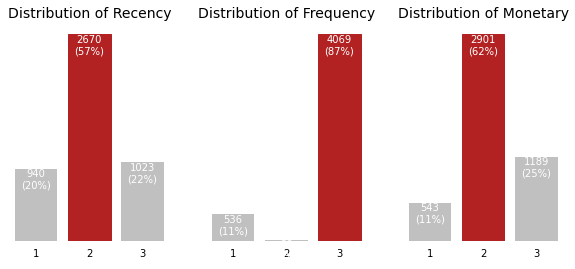

In [57]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))

for i, p in enumerate(['R', 'F', 'M']):
    parameters = {'R':'Recency', 'F':'Frequency', 'M': 'Monetary'}
    y = rfm[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y, color='silver')
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title('Distribution of {}'.format(parameters[p]),
                fontsize=14)
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('firebrick')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value - 3,
                '{}\n({}%)'.format(int(value), int(value * 100 / y.sum())),
               ha='center',
               va='top',
               color='w')

plt.show()

Простая кластеризация позволяет довольно просто интерпетировать полученные сегменты, потому что нет большого смысла их усложнять и, например, выделять внутри неуспевающих студентов ещё какую-то кагорту, такое разделение не даст полезной информации.

Основные выводы, которые можно сделать по сегментам:
1. 25% студентов считаются отличниками и могли бы претендовать на стипендию.
2. 11% студентов считаются неуспевающими и претендовали бы на отчисление.
3. Большая часть студентов успешно справляются с программами курсов и успешно сдают экзамены по ним